# DATASCI W261: Machine Learning at Scale
## Assignment Week 13
Miki Seltzer (miki.seltzer@berkeley.edu)<br>
W261-2, Spring 2016<br>
Submission: 

In [1]:
# If running locally, start PySpark
import os
import sys
spark_home = os.environ.get('SPARK_HOME', None)

if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.5.0-cdh5.5.0
      /_/

Using Python version 2.7.11 (default, Dec  6 2015 18:08:32)
SparkContext available as sc, HiveContext available as sqlContext.


# HW 13.4: Criteo Phase 2 Baseline
Using the training dataset, validation dataset and testing dataset in the Criteo bucket perform the following experiment:

- Write Spark code (borrow from Phase 1 of this project) to train a logistic regression model with the following hyperparamters:
  - Number of buckets for hashing: 1,000
  - Logistic Regression: no regularization term
  - Logistic Regression: step size = 10
  
- AWS configuration: 1 master (r3.xlarge), 4 workers (r3.xlarge)

In [6]:
rawTrainData = (sc
              .textFile('s3://criteo-dataset/rawdata/train')
              .map(lambda x: x.replace('\t', ','))
              .cache()
               )

rawValidationData = (sc
                     .textFile('s3://criteo-dataset/rawdata/validation')
                     .map(lambda x: x.replace('\t', ','))
                     .cache()
                    )

rawTestData = (sc
               .textFile('s3://criteo-dataset/rawdata/test')
               .map(lambda x: x.replace('\t', ','))
               .cache()
              )

print rawTrainData.take(1)

[u'0,1,1,5,0,1382,4,15,2,181,1,2,,2,68fd1e64,80e26c9b,fb936136,7b4723c4,25c83c98,7e0ccccf,de7995b8,1f89b562,a73ee510,a8cd5504,b2cb9c98,37c9c164,2824a5f6,1adce6ef,8ba8b39a,891b62e7,e5ba7672,f54016b9,21ddcdc9,b1252a9d,07b5194c,,3a171ecb,c5c50484,e8b83407,9727dd16']


### Hash function

In [7]:
from collections import defaultdict
import hashlib

def hashFunction(numBuckets, rawFeats, printMapping=False):
    """Calculate a feature dictionary for an observation's features based on hashing.

    Note:
        Use printMapping=True for debug purposes and to better understand how the hashing works.

    Args:
        numBuckets (int): Number of buckets to use as features.
        rawFeats (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        printMapping (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the buckets that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = {}
    for ind, category in rawFeats:
        featureString = category + str(ind)
        mapping[featureString] = int(int(hashlib.md5(featureString).hexdigest(), 16) % numBuckets)
    if(printMapping): print mapping
    sparseFeatures = defaultdict(float)
    for bucket in mapping.values():
        sparseFeatures[bucket] += 1.0
    return dict(sparseFeatures)

### Parse data to convert the string into hashed features

In [8]:
import numpy as np
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.regression import LabeledPoint

def parseHashPoint(point, numBuckets):
    """Create a LabeledPoint for this observation using hashing.

    Args:
        point (str): A comma separated string where the first value is the label and the rest are
            features.
        numBuckets: The number of buckets to hash to.

    Returns:
        LabeledPoint: A LabeledPoint with a label (0.0 or 1.0) and a SparseVector of hashed
            features.
    """
    
    fields = point.split(',')
    label = fields[0]
    features = zip(range(len(fields[1:])), fields[1:])
    
    return LabeledPoint(label, SparseVector(numBuckets, hashFunction(numBuckets, features)))

numBucketsCTR = 1000
hashTrainData = rawTrainData.map(lambda x: parseHashPoint(x, numBucketsCTR))
hashTrainData.cache()

print hashTrainData.take(1)

[LabeledPoint(0.0, (1000,[64,101,117,147,178,215,223,268,304,313,321,328,384,385,442,532,601,613,619,621,628,644,650,655,659,680,681,697,721,738,742,824,846,882,903,924],[1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


### Log-loss functions

In [9]:
from math import log

def computeLogLoss(p, y):
    """Calculates the value of log loss for a given probabilty and label.

    Note:
        log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
        and when p is 1 we need to subtract a small value (epsilon) from it.

    Args:
        p (float): A probabilty between 0 and 1.
        y (int): A label.  Takes on the values 0 and 1.

    Returns:
        float: The log loss value.
    """
    epsilon = 10e-12
    if p == 0:
        prob = epsilon
    elif p == 1:
        prob = 1 - epsilon
    else:
        prob = p * 1.
    return -(y * log(prob) + (1 - y) * log(1 - prob))

In [10]:
from math import exp #  exp(-t) = e^-t

def getP(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.

    Note:
        We'll bound our raw prediction between 20 and -20 for numerical purposes.

    Args:
        x (SparseVector): A vector with values of 1.0 for features that exist in this
            observation and 0.0 otherwise.
        w (DenseVector): A vector of weights (betas) for the model.
        intercept (float): The model's intercept.

    Returns:
        float: A probability between 0 and 1.
    """
    rawPrediction = x.dot(w) + intercept

    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    return 1 / (1 + exp(-rawPrediction))

In [11]:
def evaluateResults(model, data):
    """Calculates the log loss for the data given the model.

    Args:
        model (LogisticRegressionModel): A trained logistic regression model.
        data (RDD of LabeledPoint): Labels and features for each observation.

    Returns:
        float: Log loss for the data.
    """
    return (data
            .map(lambda x: computeLogLoss(getP(x.features, model.weights, model.intercept), x.label))
            .reduce(lambda x, y: x + y)) / data.count()

### Logistic Regression with hashed features

In [22]:
from pyspark.mllib.classification import LogisticRegressionWithSGD
import time

# fixed hyperparameters
stepSize = 10.
regType = None
numIters = 100

startTime = time.time()
model = (LogisticRegressionWithSGD
         .train(hashTrainData, iterations=numIters, step=stepSize, regType=regType)
        )
endTime = time.time()

print 'Model training with', numIters, 'iterations took', int(endTime - startTime), 'seconds.'

Model training with 100 iterations took 408 seconds.


In [23]:
model.save(sc, 's3://ms-w261-hw13/criteo_baseline_100iter')

### Report in tabular form  the logLossTest for the Training, Validation, and Testing datasets.

In [25]:
logLossTrain = evaluateResults(model, hashTrainData)

hashValidationData = rawValidationData.map(lambda x: parseHashPoint(x, numBucketsCTR)).cache()
logLossVal = evaluateResults(model, hashValidationData)

hashTestData = rawTestData.map(lambda x: parseHashPoint(x, numBucketsCTR)).cache()
logLossTest = evaluateResults(model, hashTestData)

print 'Table 1: Logloss values for each data set using logistic regression model\n'

print '{:12s}{:10s}'.format('Data set', 'Logloss')
print '-'*22

table1 = '{:12s}{:10.8f}'.format
print table1('Train', logLossTrain)
print table1('Validation', logLossVal)
print table1('Test', logLossTest)

Table 1: Logloss values for each data set using logistic regression model

Data set    Logloss   
----------------------
Train       0.50505746
Validation  0.50526198
Test        0.50519185


### Report in tabular form the AUC value for the Training, Validation, and Testing datasets.

In [42]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

def getAUC(model, data):
    metrics = BinaryClassificationMetrics(data.map(lambda lp: (float(model.predict(lp.features)), lp.label)))
    return metrics.areaUnderROC

trainAUC = getAUC(model, hashTrainData)
valAUC = getAUC(model, hashValidationData)
testAUC = getAUC(model, hashTestData)

print 'Table 2: AUC values for each data set using logistic regression model\n'

print '{:12s}{:10s}'.format('Data set', 'AUC')
print '-'*22

table1 = '{:12s}{:10.8f}'.format
print table1('Train', trainAUC)
print table1('Validation', valAUC)
print table1('Test', testAUC)

Table 2: AUC values for each data set using logistic regression model

Data set    AUC       
----------------------
Train       0.58009052
Validation  0.58026576
Test        0.58020823


# HW 13.5: Criteo Phase 2 Hyperparameter Tuning
Experiment with various hyperparameters, including:
- Number of hashing buckets (explore values of 1,000 and 10,000 and others)
- Regularization term (1e-6, 1e-3 and others)
- Step size (start with 1, then others)

In [4]:
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.evaluation import BinaryClassificationMetrics

def getAUC(model, data):
    metrics = BinaryClassificationMetrics(data.map(lambda lp: (float(model.predict(lp.features)), lp.label)))
    return metrics.areaUnderROC

In [34]:
# Fixed hyperparameters
numHashBuckets = [100, 1000, 10000]
regType = 'l2'
regParams = [1e-6, 1e-3, 1e-1]
stepSizes = [10, 1, 0.1]
numIters = 10

In [35]:
bestModel = None
bestLogloss = 1e9

print ('{:>13s}{:>10s}{:>10s}{:>10s}{:>10s}'
       .format('hashBuckets', 'regParam', 'stepSize', 'trainTime', 'LL_val'))
print '-'*53

for h in numHashBuckets:
    # Create hashed feature RDDs
    hashTrainData = rawTrainData.map(lambda x: parseHashPoint(x, h)).cache()
    hashValidationData = rawValidationData.map(lambda x: parseHashPoint(x, h)).cache()
    
    for r in regParams:
        for s in stepSizes:
            startTime = time.time()
            model1 = (LogisticRegressionWithSGD
                      .train(hashTrainData, iterations=numIters, step=s, regType=regType, regParam=r)
                     )
            endTime = time.time()
    
            valLL = evaluateResults(model1, hashValidationData)
        
            print ('{:13d}{:10.0e}{:10.1f}{:10d}{:10.5f}'
                   .format(h, r, s, int(endTime - startTime), valLL))
            
            if valLL < bestLogloss:
                bestModel = model1
                bestLogloss = valLL

  hashBuckets  regParam  stepSize trainTime    LL_val
-----------------------------------------------------------------------------------
          100     1e-06      10.0       984   1.82397
          100     1e-06       1.0        41   0.54596
          100     1e-06       0.1        41   0.56565
          100     1e-03      10.0        39   2.11433
          100     1e-03       1.0        40   0.54599
          100     1e-03       0.1        42   0.56565
          100     1e-01      10.0        40   3.65541
          100     1e-01       1.0        41   0.54905
          100     1e-01       0.1        41   0.56599
         1000     1e-06      10.0      1049   0.75516
         1000     1e-06       1.0        52   0.54177
         1000     1e-06       0.1        52   0.58065
         1000     1e-03      10.0        48   0.83817
         1000     1e-03       1.0        49   0.54181
         1000     1e-03       0.1        49   0.58067
         1000     1e-01      10.0        48   1.2607

In [37]:
bestModel.save(sc, 's3://ms-w261-hw13/criteo_bestModel1')

#### It looks like having 10,000 buckets consistently produces lower logloss values, let's stick with that number. We'll get more granular with the regularization parameters, and zoom in on stepSizes centered on 1.

In [46]:
# Fixed hyperparameters
h = 10000
regParams = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
stepSizes = [5, 1, 0.5]

In [41]:
bestModel2 = None
bestLogloss2 = 1e9

logLosses = []
AUCs = []

print ('{:>13s}{:>10s}{:>10s}{:>10s}{:>10s}'
       .format('hashBuckets', 'regParam', 'stepSize', 'trainTime', 'LL_val'))
print '-'*53
    
for r in regParams:
    for s in stepSizes:
        startTime = time.time()
        model2 = (LogisticRegressionWithSGD
                  .train(hashTrainData, iterations=numIters, step=s, regType=regType, regParam=r)
                 )
        endTime = time.time()

        valLL = evaluateResults(model2, hashValidationData)
        valAUC = getAUC(model2, hashValidationData)

        logLosses.append([r, s, valLL])
        AUCs.append([r, s, valAUC])
        
        print ('{:13d}{:10.0e}{:10.1f}{:10d}{:10.5f}'
               .format(h, r, s, int(endTime - startTime), valLL))

        if valLL < bestLogloss2:
            bestModel2 = model2
            bestLogloss2 = valLL

  hashBuckets  regParam  stepSize trainTime    LL_val
-----------------------------------------------------
        10000     1e-06       5.0        48   0.53819
        10000     1e-06       1.0        48   0.54115
        10000     1e-06       0.5        48   0.55176
        10000     1e-05       5.0        49   0.53820
        10000     1e-05       1.0        49   0.54115
        10000     1e-05       0.5        48   0.55176
        10000     1e-04       5.0        47   0.53826
        10000     1e-04       1.0        48   0.54116
        10000     1e-04       0.5        48   0.55176
        10000     1e-03       5.0        48   0.53883
        10000     1e-03       1.0        48   0.54120
        10000     1e-03       0.5        49   0.55177
        10000     1e-02       5.0        49   0.54752
        10000     1e-02       1.0        48   0.54162
        10000     1e-02       0.5        48   0.55194
        10000     1e-01       5.0        48   0.58471
        10000     1e-01     

In [46]:
# In case we lose connection and need to reload these!
print logLosses
print AUCs

[[1e-06, 5, 0.5381945595699974], [1e-06, 1, 0.5411535575705866], [1e-06, 0.5, 0.5517564699843335], [1e-05, 5, 0.5382000828365382], [1e-05, 1, 0.5411539714508792], [1e-05, 0.5, 0.5517566304915823], [0.0001, 5, 0.5382554892006085], [0.0001, 1, 0.5411581105158698], [0.0001, 0.5, 0.5517582359285195], [0.001, 5, 0.5388282611574104], [0.001, 1, 0.5411995272488614], [0.001, 0.5, 0.5517743266845319], [0.01, 5, 0.5475238092617305], [0.01, 1, 0.5416161822138278], [0.01, 0.5, 0.5519388154658781], [0.1, 5, 0.5847096063714977], [0.1, 1, 0.5459317073016486], [0.1, 0.5, 0.5538896516404738]]
[[1e-06, 5, 0.6213779310550208], [1e-06, 1, 0.49999970672534505], [1e-06, 0.5, 0.5], [1e-05, 5, 0.6213781662142314], [1e-05, 1, 0.49999970672534505], [1e-05, 0.5, 0.5], [0.0001, 5, 0.621389655604656], [0.0001, 1, 0.49999970672534505], [0.0001, 0.5, 0.5], [0.001, 5, 0.6215083080101218], [0.001, 1, 0.49999970672534505], [0.001, 0.5, 0.5], [0.01, 5, 0.624681753311662], [0.01, 1, 0.49999970672534505], [0.01, 0.5, 0.5]

In [43]:
bestModel2.save(sc, 's3://ms-w261-hw13/criteo_bestModel2')

## Report in tabular form and using heatmaps the AUC and logloss values for training, validation and testing datasets

In [114]:
def plotHeatmap(d, title):
    data = np.array(d)
    data = data[data[:,0].argsort()]
    data = data[:, 2]
    data = np.transpose(np.reshape(data, (len(regParams), len(stepSizes))))
    
    s = list(stepSizes)
    r = list(regParams)
    
    plt.figure(figsize=(6,6))
    ax = plt.subplot(1, 1, 1)
    plt.imshow(data, cmap='Purples', interpolation='nearest')
    ax.set_yticks(range(3))
    ax.set_yticklabels(s)
    ax.set_xticks(range(6))
    ax.set_xticklabels(r)
    plt.ylabel('Step Sizes')
    plt.xlabel('Regularization Param')
    plt.title(title)
    
    labels = np.round(data.flatten(), 5)
    xs = range(6)*3
    yTemp = [[x]*6 for x in range(3)]
    ys = [item for sublist in yTemp for item in sublist]
    colors = np.where(labels > np.percentile(labels, 75), "white", "black")
    
    for label, x, y, col in zip(labels, xs, ys, colors):
        plt.annotate(label, xy=(x,y), xytext=(-1,0), textcoords='offset points', ha='center', va='center', color=col)

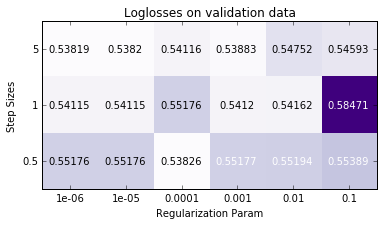

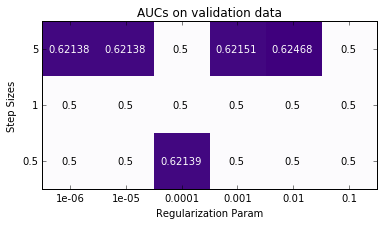

In [115]:
plotHeatmap(logLosses, 'Loglosses on validation data')
plotHeatmap(AUCs, 'AUCs on validation data')

In [5]:
bestModel2 = LogisticRegressionModel.load(sc, 's3://ms-w261-hw13/criteo_bestModel2')

In [12]:
# Make sure we have data with the correct number of hash buckets
numBucketsCTR = 10000

hashTrainData = rawTrainData.map(lambda x: parseHashPoint(x, numBucketsCTR)).cache()
hashValidationData = rawValidationData.map(lambda x: parseHashPoint(x, numBucketsCTR)).cache()
hashTestData = rawTestData.map(lambda x: parseHashPoint(x, numBucketsCTR)).cache()

In [13]:
# Get AUC and logloss on each data set with our best model
trainLL = evaluateResults(bestModel2, hashTrainData)
trainAUC = getAUC(bestModel2, hashTrainData)

valLL = evaluateResults(bestModel2, hashValidationData)
valAUC = getAUC(bestModel2, hashValidationData)

testLL = evaluateResults(bestModel2, hashTestData)
testAUC = getAUC(bestModel2, hashTestData)

In [19]:
print 'Table 3: Logloss and AUC values for each data set using logistic regression model #2'
print '- Hash buckets: 10,000'
print '- Regularization param: 1e-6'
print '- Step size: 5'

print '\n'
print '{:12s}{:10s}{:10s}'.format('Data set', 'Logloss', 'AUC')
print '-'*32

table1 = '{:12s}{:<10.6f}{:<10.6f}'.format
print table1('Train', trainLL, trainAUC)
print table1('Validation', valLL, valAUC)
print table1('Test', testLL, testAUC)

Table 3: Logloss and AUC values for each data set using logistic regression model #2
- Hash buckets: 10,000
- Regularization param: 1e-6
- Step size: 5


Data set    Logloss   AUC       
--------------------------------
Train       0.538096  0.621230  
Validation  0.538195  0.621378  
Test        0.538053  0.621274  


### Discuss the optimal setting to solve this problem  in terms of the following:
- Features
- Learning algortihm
- Spark cluster

#### Justify your recommendations based on your experimental results and cross reference with table numbers and figure numbers. Also highlight key results with annotations, both textual and line and box based, on your tables and graphs.

Based on the hyperparameters explored in the above analysis, the recommendation would be to use a logistic regression model on data that has been hashed to 10,000 buckets. In the logistic regression model, the hyperparameters of regularization parameter = 1e-6 and step size = 5 produce the lowest logloss value on the validation data (0.538195, found in table 3), as well as the highest AUC value (0.621378, found in table 3).

The grid search was performed only using 10 iterations, which was done to save time. Running 100 iterations on each training run would have been extremely time intensive, even using a cluster with nearly 90 GB memory.